In [1]:
import __init__
from __init__ import DATA_PATH, PACKAGE_PATH
from dce import DCE
from cluster import Cluster
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Model
%matplotlib inline

Using TensorFlow backend.


In [2]:
from descriptor import rdkitDescriptors as rDesc

(array([673.,   0.,   0.,   0.,   0., 191.,   0.,   0.,   0., 199.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

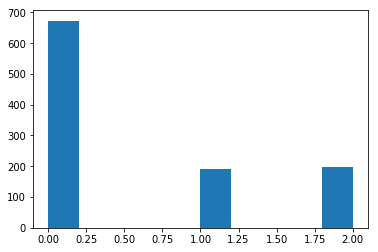

In [61]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])

df['tri_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [20,80])
true_label_triclass = df['tri_class_partition'].values

df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(true_label_triclass)

In [5]:
fps = rDesc.batch_compute_MACCSkeys(df['SMILES'])

In [6]:
len(fps[0])

167

### autoencoder

In [7]:
from dimreducer import DeepAutoEncoder as DAE
dims = [167, 80, 40]
autoencoder = DAE(dims)
autoencoder.build_model()
history = autoencoder.train_model(fps, epochs=50,verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


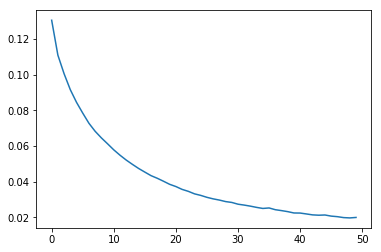

In [8]:
plt.plot(history.history['loss'])

### confusion matrix visualization tool

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## cluster = 2

In [31]:
class_names = np.array(["nondegradable", "degradable"])

In [11]:
from sklearn.model_selection import train_test_split


### test on baseline model: just supervised learning (raw fingerprint)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    fps, true_label_biclass, test_size=0.25, random_state=42)

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
clf_base = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42)
clf_base.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [35]:
y_pred_base=clf_base.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import hamming_loss, hinge_loss

In [15]:
def classifier_losses(y_true, y_pred,normalize = True):
    loss_dict = {}
    loss_dict['hamming_loss'] = hamming_loss(y_true, y_pred)
    loss_dict['hinge_loss'] = hinge_loss(y_true, y_pred)
    return loss_dict

In [38]:
accuracy_score(y_test, y_pred_base)

0.8308270676691729

In [39]:
classifier_losses(y_test, y_pred_base)

{'hamming_loss': 0.16917293233082706, 'hinge_loss': 0.8796992481203008}

In [40]:
log_loss(y_test, clf_base.predict_proba(X_test), normalize=True, labels=y_test)

0.40475265521986775

Normalized confusion matrix
[[0.93 0.07]
 [0.42 0.58]]


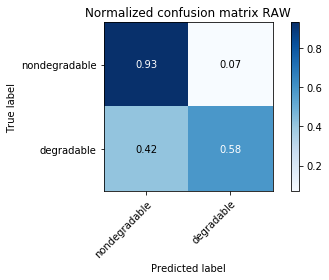

In [41]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_base, classes=class_names, normalize=True,
                      title='Normalized confusion matrix RAW')

### test on autoencoder + supervised learning  
Extract the hidden layer, and apply train-test split on hidden layer to generate classifier

In [96]:
dims =[167,100,50]
autoencoder = DAE(dims, act='relu')
autoencoder.build_model(norm=False)
history = autoencoder.train_model(fps, loss="binary_crossentropy", verbose=0, epochs=50)

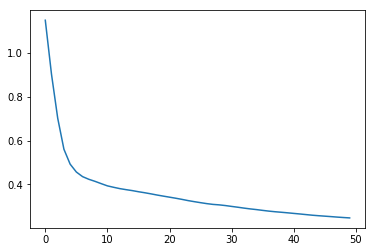

In [97]:
plt.plot(history.history['loss'])

In [117]:
encoder = Model(inputs=autoencoder.model.input, 
                outputs=autoencoder.model.get_layer(name='embedding_layer').output)
hidden_feat = encoder.predict(fps)
X_train_hid, X_test_hid, y_train_ae, y_test_ae = train_test_split(hidden_feat, true_label_biclass, test_size=0.25, random_state=42)
clf_ae = RandomForestClassifier(n_estimators=50, max_depth=8,random_state=42) # n_esimators is reduced because dimension is reduced
clf_ae.fit(X_train_hid, y_train_ae)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [118]:
y_pred_ae=clf_ae.predict(X_test_hid)

In [119]:
accuracy_score(y_test_ae, y_pred_ae)

0.868421052631579

In [121]:
classifier_losses(y_test, y_pred_ae)

{'hamming_loss': 0.13157894736842105, 'hinge_loss': 0.8421052631578947}

In [124]:
log_loss(y_test_ae, clf_ae.predict_proba(X_test_hid), normalize=True, labels=y_test_ae)

0.3634465280507357

Normalized confusion matrix
[[0.93 0.07]
 [0.42 0.58]]
Normalized confusion matrix
[[0.92 0.08]
 [0.26 0.74]]


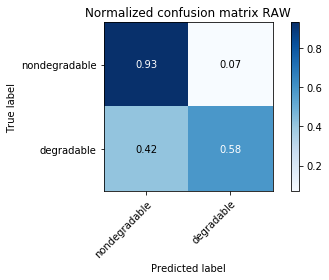

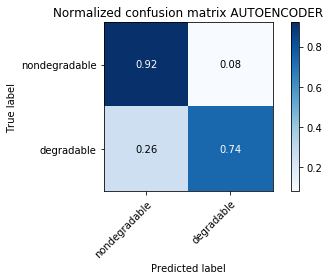

In [126]:
np.set_printoptions(precision=2)


# Plot normalized confusion matrix RAW
plot_confusion_matrix(y_test, y_pred_base, classes=class_names, normalize=True,
                      title='Normalized confusion matrix RAW')

# Plot normalized confusion matrix AUTOENCODER
plot_confusion_matrix(y_test_ae, y_pred_ae, classes=class_names, normalize=True,
                      title='Normalized confusion matrix AUTOENCODER')

### test supervised dce


In [337]:
X_train, X_test, y_train, y_test = train_test_split(
    fps, true_label_biclass, test_size=0.25, random_state=42)

In [338]:
autoencoder_dims = [167, 120, 60]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=20)
cl_weights = np.arange(0.1, 1, 0.1)
train_loss = []
test_loss = []
train_hidden_feats = []
test_hidden_feats = []
train_y_pred = []
test_y_pred = []

for cl_weight in cl_weights:
    dce.build_model(norm=True)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    train_loss_i, test_loss_i = dce.train_model(data_train=X_train, labels_train=y_train,
                                                data_test=X_test, labels_test=y_test,
                                                clustering_loss='kld', decoder_loss='binary_crossentropy',
                                                verbose=0,clustering_loss_weight=cl_weight,decay=10e-6)
    train_loss.append(train_loss_i)
    test_loss.append(test_loss_i)
    
    q, _ = dce.model.predict(X_train)
    train_y_pred.append(q.argmax(1))
    
    q, _ = dce.model.predict(X_test)
    test_y_pred.append(q.argmax(1))
    
    encoder = Model(inputs=dce.model.input, 
                    outputs=dce.model.get_layer(name='embedding_layer').output)
    
    train_hidden_feats.append(encoder.predict(X_train))
    test_hidden_feats.append(encoder.predict(X_test))
    
    print('Training finished and the results are recorded')

Start to train model with cluster weight: 0.1
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.7000000000000001

#### Losses 

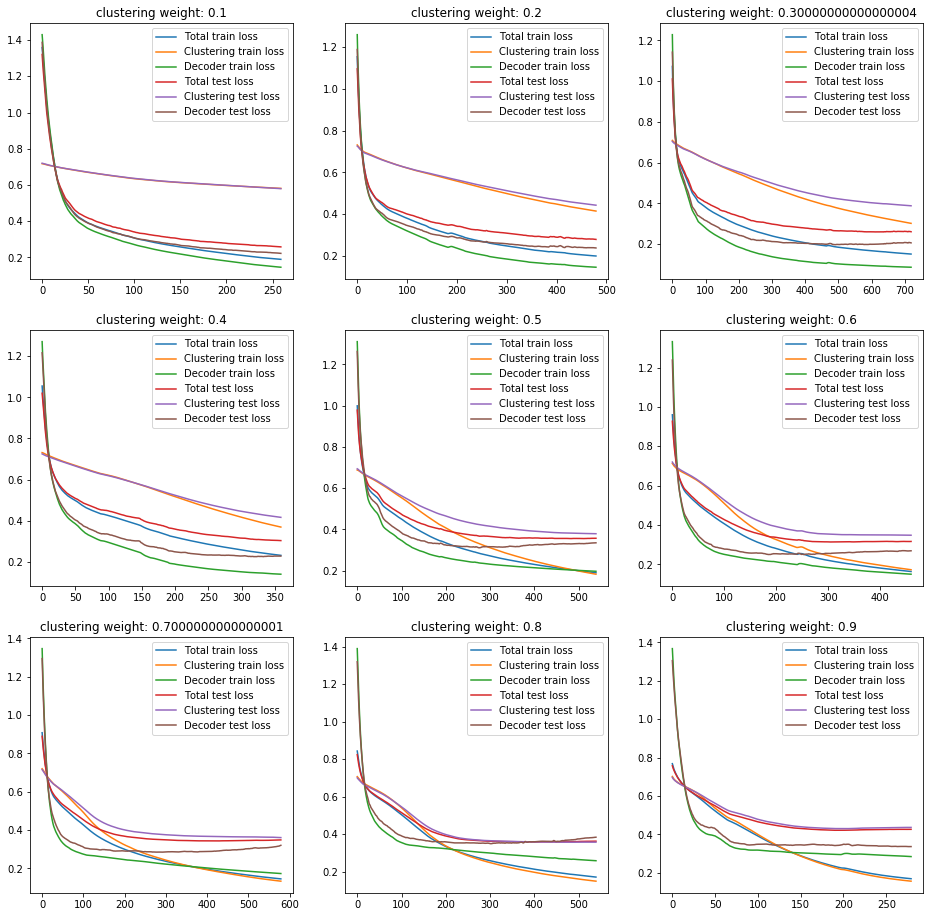

In [339]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3

    ax[row_i][column_j].plot(train_loss[i][0],label='Total train loss')
    ax[row_i][column_j].plot(train_loss[i][1],label='Clustering train loss')
    ax[row_i][column_j].plot(train_loss[i][2],label='Decoder train loss')
    ax[row_i][column_j].plot(test_loss[i][0],label='Total test loss')
    ax[row_i][column_j].plot(test_loss[i][1],label='Clustering test loss')
    ax[row_i][column_j].plot(test_loss[i][2],label='Decoder test loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

#### Scores

Text(0.5, 1.0, 'Test fowlkes_mallows_score')

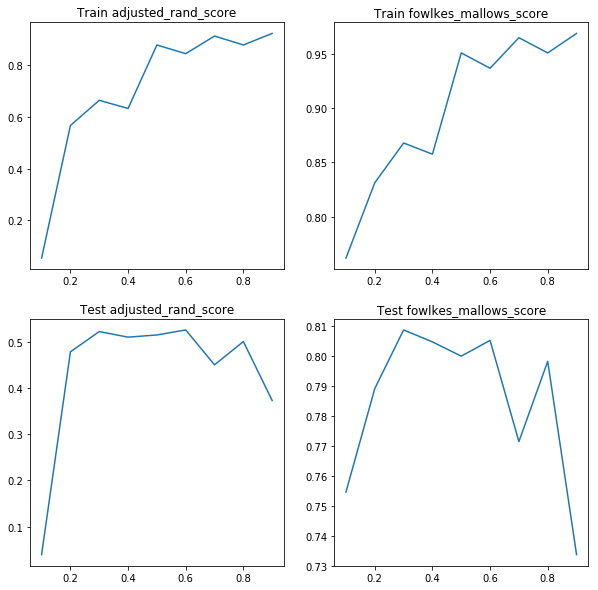

In [340]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(y_train,train_y_pred[i],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(2,2,figsize=(10,10))

ax[0][0].plot(cl_weights,adjusted_rand_score)
ax[0][0].set_title('Train adjusted_rand_score')

ax[0][1].plot(cl_weights,fowlkes_mallows_score)
ax[0][1].set_title('Train fowlkes_mallows_score')

adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(y_test,test_y_pred[i],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

ax[1][0].plot(cl_weights,adjusted_rand_score)
ax[1][0].set_title('Test adjusted_rand_score')

ax[1][1].plot(cl_weights,fowlkes_mallows_score)
ax[1][1].set_title('Test fowlkes_mallows_score')

#### Train Visualization using true label

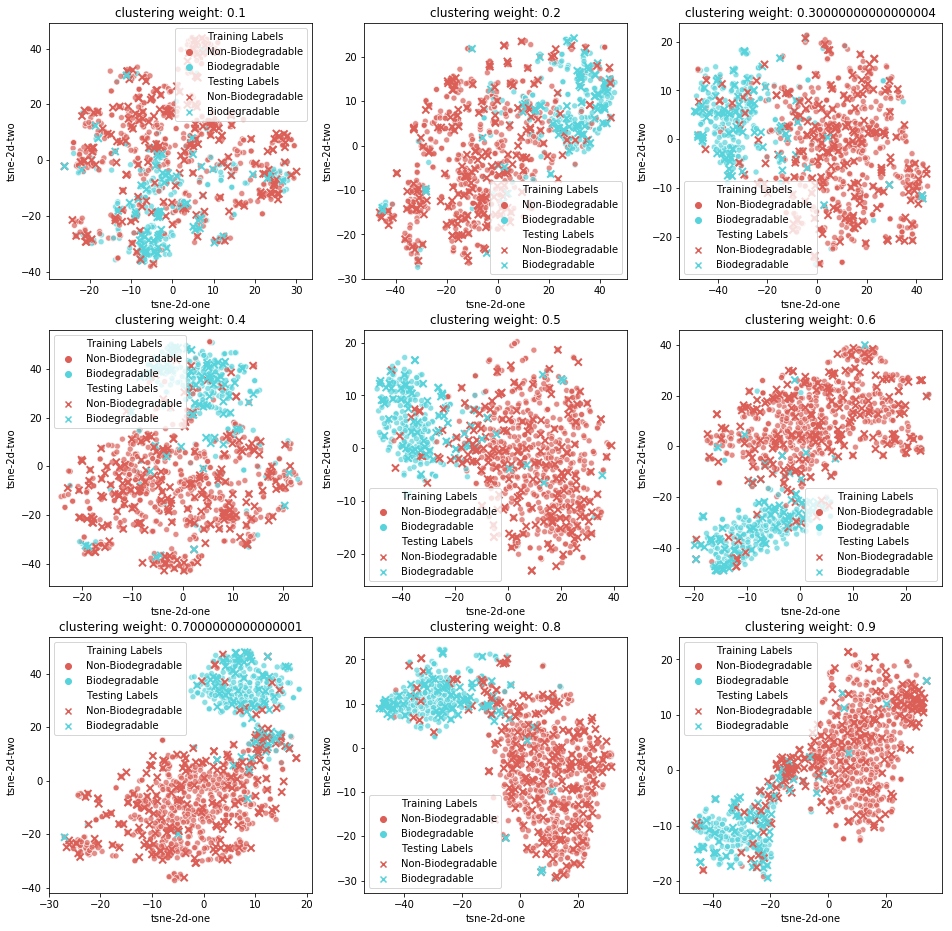

In [344]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization_test_and_train(
        train_feat=train_hidden_feats[i], 
        train_labels=y_train,
        test_feat=test_hidden_feats[i],
        test_labels=y_test,
        labels=['Non-Biodegradable', 'Biodegradable'],
        verbose=0,
        ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

### Take out the predicted result from the DCE and use same metrics to calculate classifier loss

Normalized confusion matrix
[[0.98 0.02]
 [0.94 0.06]]
Normalized confusion matrix
[[0.91 0.09]
 [0.29 0.71]]
Normalized confusion matrix
[[0.93 0.07]
 [0.27 0.73]]
Normalized confusion matrix
[[0.93 0.07]
 [0.29 0.71]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.23 0.77]]
Normalized confusion matrix
[[0.91 0.09]
 [0.23 0.77]]
Normalized confusion matrix
[[0.88 0.12]
 [0.26 0.74]]
Normalized confusion matrix
[[0.92 0.08]
 [0.27 0.73]]
Normalized confusion matrix
[[0.85 0.15]
 [0.27 0.73]]


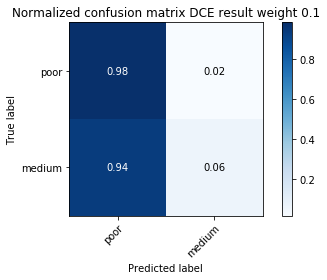

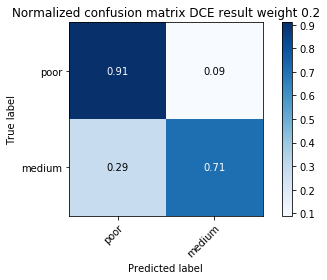

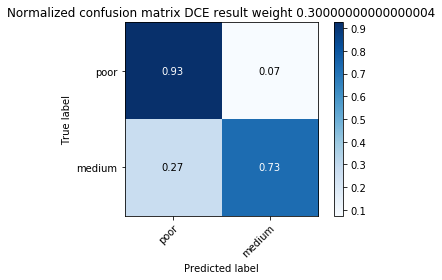

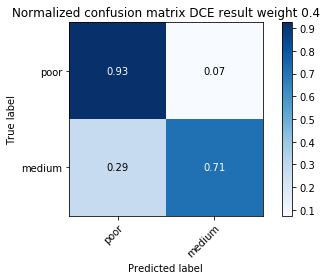

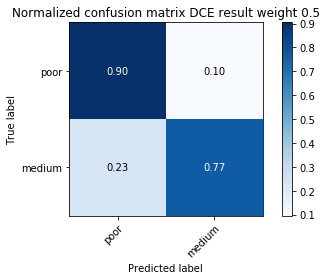

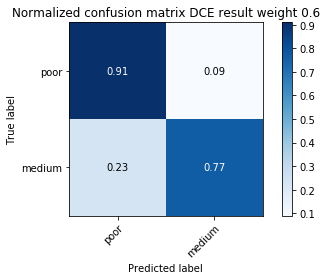

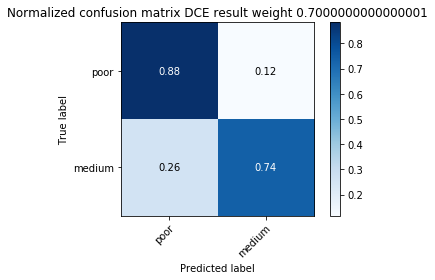

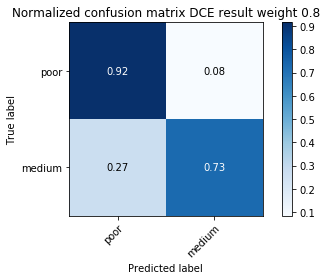

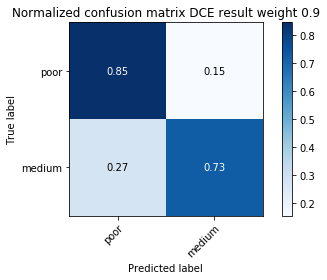

In [345]:
acc_scores_dce = []
classifier_losses_dce = []
for i in range(9):
    acc_scores_dce.append(accuracy_score(y_test,test_y_pred[i]))
    classifier_losses_dce.append(classifier_losses(y_test, test_y_pred[i]))
    plot_confusion_matrix(y_test, test_y_pred[i], classes=class_names, normalize=True,
                      title='Normalized confusion matrix DCE result weight ' + str(cl_weights[i]) )

    

In [346]:
max(acc_scores_dce) # weight = 0.6

0.868421052631579

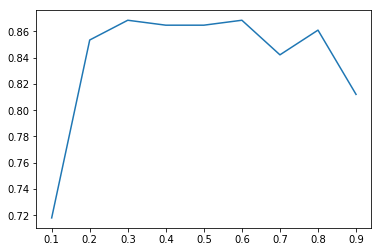

In [347]:
plt.plot(cl_weights,acc_scores_dce)


In [228]:
classifier_losses_dce

[{'hamming_loss': 0.14661654135338345, 'hinge_loss': 0.8571428571428571},
 {'hamming_loss': 0.15413533834586465, 'hinge_loss': 0.8646616541353384},
 {'hamming_loss': 0.16541353383458646, 'hinge_loss': 0.8759398496240601},
 {'hamming_loss': 0.13909774436090225, 'hinge_loss': 0.849624060150376},
 {'hamming_loss': 0.16165413533834586, 'hinge_loss': 0.8721804511278195},
 {'hamming_loss': 0.15037593984962405, 'hinge_loss': 0.8609022556390977},
 {'hamming_loss': 0.12781954887218044, 'hinge_loss': 0.8383458646616542},
 {'hamming_loss': 0.14661654135338345, 'hinge_loss': 0.8571428571428571},
 {'hamming_loss': 0.17669172932330826, 'hinge_loss': 0.8872180451127819}]

* Without early stopping, it tend to overfit, and best accuaracy score is just slight higher than autoencoder 

## cluster = 3

In [62]:
class_names = np.array(["poor", "medium","good"])

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [348]:
X_train, X_test, y_train, y_test = train_test_split(
   fps, true_label_triclass, test_size=0.25, random_state=42)

### test on baseline model: just supervised learning

In [111]:
clf3_base = RandomForestClassifier(n_estimators=130, max_depth=9,random_state=42)
clf3_base.fit(X_train, y_train)
y_pred_base=clf3_base.predict(X_test)

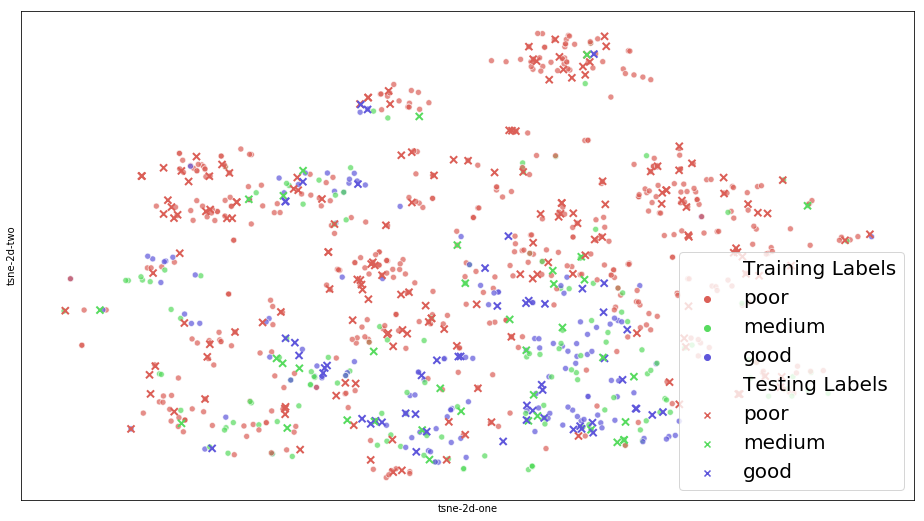

In [112]:
fig, ax =plt.subplots(figsize=(16,9))

utilities.tsne_2d_visulization_test_and_train(
    train_feat=X_train, 
    train_labels=y_train,
    test_feat=X_test,
    test_labels=y_test,
    labels=['poor', 'medium','good'],
    verbose=0,
    ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.legend(fontsize=20)
#plt.savefig('4.co_train_classifying.pdf', bbox_inches='tight')

In [113]:
accuracy_score(y_test,y_pred_base)

0.7669172932330827

In [114]:
hamming_loss(y_test, y_pred_base)

0.23308270676691728

In [115]:
log_loss(y_test, clf3_base.predict_proba(X_test), normalize=True, labels=y_test)

0.5999474010520238

Normalized confusion matrix
[[0.95 0.02 0.02]
 [0.45 0.11 0.45]
 [0.24 0.13 0.63]]


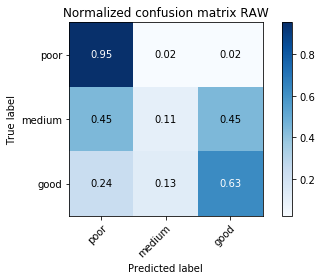

In [116]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_base, classes=class_names, normalize=True,
                      title='Normalized confusion matrix RAW')

### test on autoencoder + supervised learning

In [118]:
from dimreducer import DeepAutoEncoder as DAE

In [284]:
dims =[167,100,50]
autoencoder = DAE(dims, act='relu')
autoencoder.build_model(norm=False)
history = autoencoder.train_model(fps, loss="binary_crossentropy", verbose=0, epochs=75)

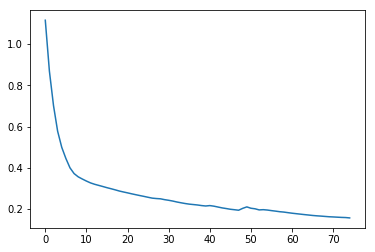

In [285]:
plt.plot(history.history['loss'])

In [328]:
encoder = Model(inputs=autoencoder.model.input, 
                outputs=autoencoder.model.get_layer(name='embedding_layer').output)
hidden_feat = encoder.predict(fps)
X_train_hid, X_test_hid, y_train_ae, y_test_ae = train_test_split(hidden_feat, true_label_triclass, test_size=0.25, random_state=42)
clf3_ae = RandomForestClassifier(n_estimators=57, max_depth=6,random_state=42) # n_esimators is reduced because dimension is reduced
clf3_ae.fit(X_train_hid, y_train_ae)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=57, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [329]:
y_pred_ae=clf3_ae.predict(X_test_hid)

In [330]:
accuracy_score(y_test_ae, y_pred_ae) # best score

0.7669172932330827

In [332]:
hamming_loss(y_test_ae, y_pred_ae)

0.23308270676691728

In [335]:
log_loss(y_test_ae, clf3_ae.predict_proba(X_test_hid), normalize=True, labels=y_test_ae)

0.6038612120346109

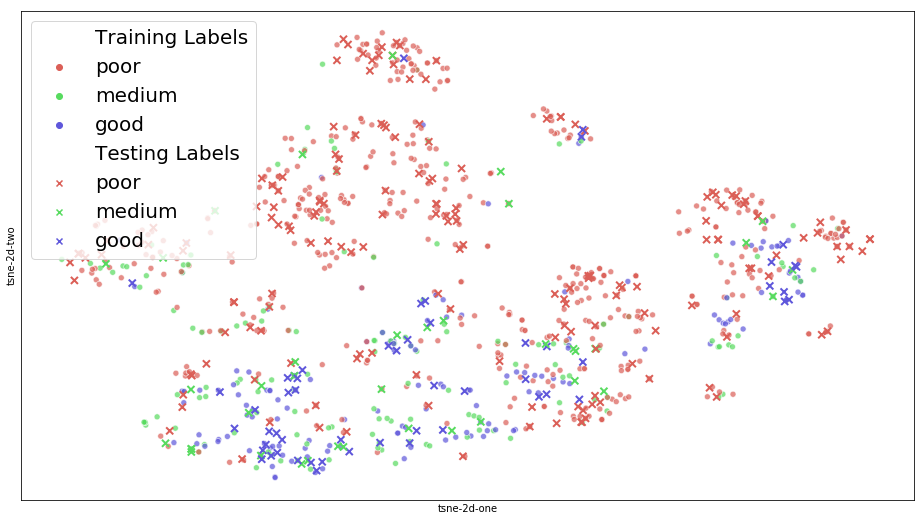

In [336]:
fig, ax =plt.subplots(figsize=(16,9))

utilities.tsne_2d_visulization_test_and_train(
    train_feat=X_train_hid, 
    train_labels=y_train_ae,
    test_feat=X_test_hid,
    test_labels=y_test_ae,
    labels=['poor', 'medium','good'],
    verbose=0,
    ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.legend(fontsize=20)
#plt.savefig('4.co_train_classifying.pdf', bbox_inches='tight')

Normalized confusion matrix
[[0.95 0.02 0.02]
 [0.45 0.11 0.45]
 [0.24 0.13 0.63]]
Normalized confusion matrix
[[0.96 0.04 0.  ]
 [0.53 0.16 0.32]
 [0.33 0.09 0.57]]


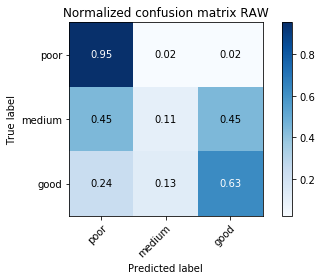

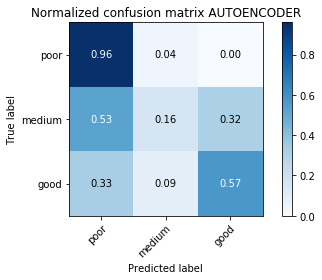

In [333]:
# Plot normalized confusion matrix RAW
plot_confusion_matrix(y_test, y_pred_base, classes=class_names, normalize=True,
                      title='Normalized confusion matrix RAW')

# Plot normalized confusion matrix AUTOENCODER
plot_confusion_matrix(y_test_ae, y_pred_ae, classes=class_names, normalize=True,
                      title='Normalized confusion matrix AUTOENCODER')

* accuracy score and loss are almost same, but confusion matrix different  
the medium class prediction is a little better, and the error is more towards the "poor" side

## co-optimized

In [351]:
autoencoder_dims = [167, 120, 60]
dce = DCE(autoencoder_dims, n_clusters=3, update_interval=20)
cl_weights = np.arange(0.1, 1, 0.1)
train_loss = []
test_loss = []
train_hidden_feats = []
test_hidden_feats = []
train_y_pred = []
test_y_pred = []

for cl_weight in cl_weights:
    dce.build_model(norm=True)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    train_loss_i, test_loss_i = dce.train_model(data_train=X_train, labels_train=y_train,
                                                data_test=X_test, labels_test=y_test,
                                                clustering_loss='kld', decoder_loss='binary_crossentropy',
                                                verbose=0,clustering_loss_weight=cl_weight, decay = 1e-5)
    train_loss.append(train_loss_i)
    test_loss.append(test_loss_i)
    
    q, _ = dce.model.predict(X_train)
    train_y_pred.append(q.argmax(1))
    
    q, _ = dce.model.predict(X_test)
    test_y_pred.append(q.argmax(1))
    
    encoder = Model(inputs=dce.model.input, 
                    outputs=dce.model.get_layer(name='embedding_layer').output)
    
    train_hidden_feats.append(encoder.predict(X_train))
    test_hidden_feats.append(encoder.predict(X_test))
    
    print('Training finished and the results are recorded')

Start to train model with cluster weight: 0.1
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.7000000000000001

#### Losses

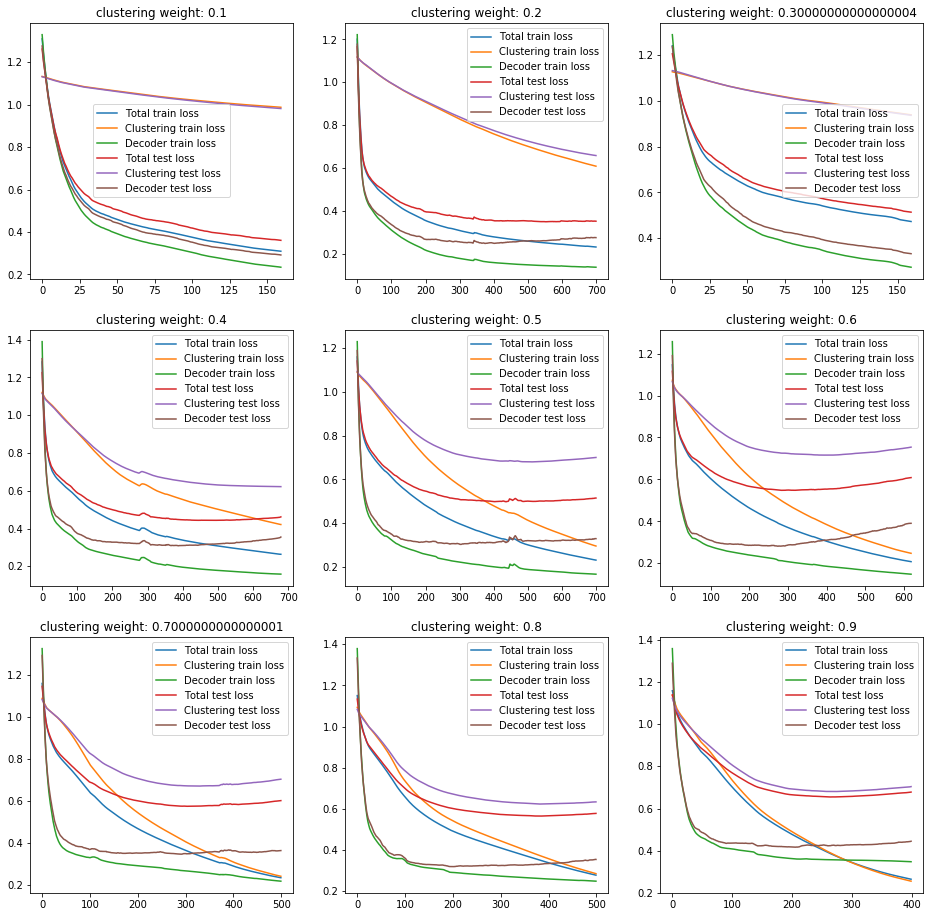

In [352]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3

    ax[row_i][column_j].plot(train_loss[i][0],label='Total train loss')
    ax[row_i][column_j].plot(train_loss[i][1],label='Clustering train loss')
    ax[row_i][column_j].plot(train_loss[i][2],label='Decoder train loss')
    ax[row_i][column_j].plot(test_loss[i][0],label='Total test loss')
    ax[row_i][column_j].plot(test_loss[i][1],label='Clustering test loss')
    ax[row_i][column_j].plot(test_loss[i][2],label='Decoder test loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

#### Scores

Text(0.5, 1.0, 'Test fowlkes_mallows_score')

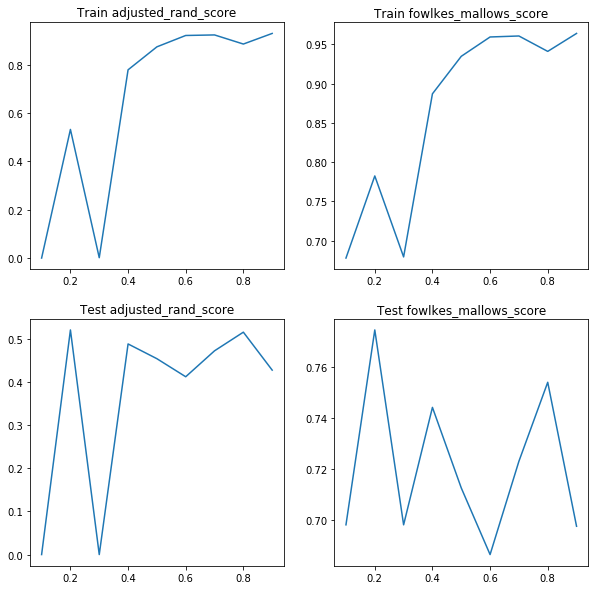

In [353]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(y_train,train_y_pred[i],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(2,2,figsize=(10,10))

ax[0][0].plot(cl_weights,adjusted_rand_score)
ax[0][0].set_title('Train adjusted_rand_score')

ax[0][1].plot(cl_weights,fowlkes_mallows_score)
ax[0][1].set_title('Train fowlkes_mallows_score')

adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(y_test,test_y_pred[i],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

ax[1][0].plot(cl_weights,adjusted_rand_score)
ax[1][0].set_title('Test adjusted_rand_score')

ax[1][1].plot(cl_weights,fowlkes_mallows_score)
ax[1][1].set_title('Test fowlkes_mallows_score')

#### Train Visualization using true label

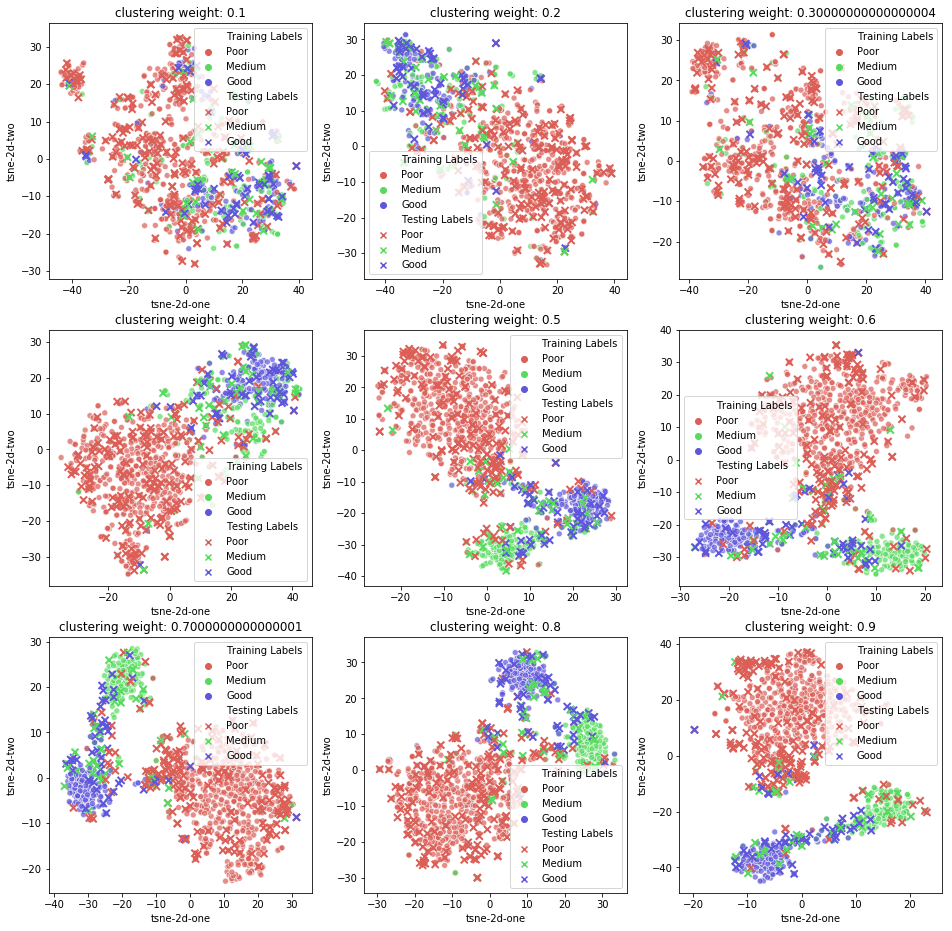

In [354]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization_test_and_train(
        train_feat=train_hidden_feats[i], 
        train_labels=y_train,
        test_feat=test_hidden_feats[i],
        test_labels=y_test,
        labels=['Poor', 'Medium','Good'],
        verbose=0,
        ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

Normalized confusion matrix
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Normalized confusion matrix
[[0.94 0.04 0.02]
 [0.39 0.08 0.53]
 [0.22 0.04 0.74]]
Normalized confusion matrix
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Normalized confusion matrix
[[0.89 0.07 0.04]
 [0.34 0.05 0.61]
 [0.17 0.13 0.7 ]]
Normalized confusion matrix
[[0.85 0.09 0.06]
 [0.32 0.26 0.42]
 [0.11 0.31 0.57]]
Normalized confusion matrix
[[0.83 0.09 0.08]
 [0.26 0.37 0.37]
 [0.15 0.37 0.48]]
Normalized confusion matrix
[[0.86 0.07 0.07]
 [0.26 0.29 0.45]
 [0.13 0.37 0.5 ]]
Normalized confusion matrix
[[0.9  0.06 0.03]
 [0.32 0.29 0.39]
 [0.15 0.37 0.48]]
Normalized confusion matrix
[[0.84 0.13 0.03]
 [0.26 0.39 0.34]
 [0.17 0.35 0.48]]


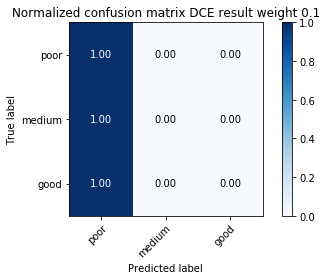

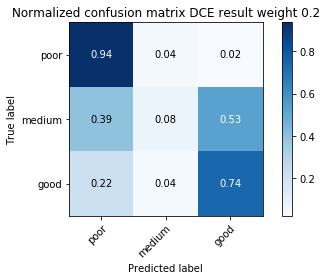

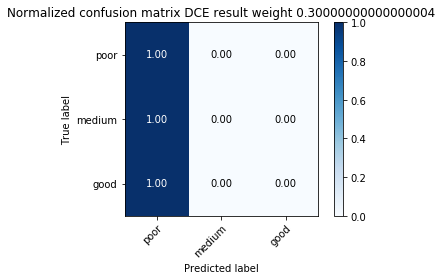

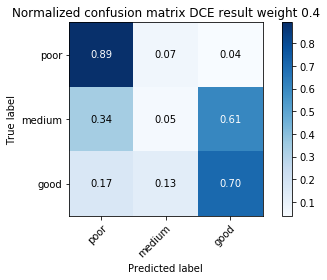

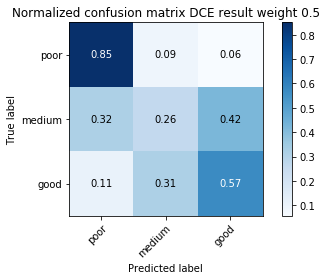

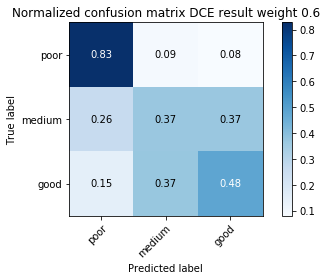

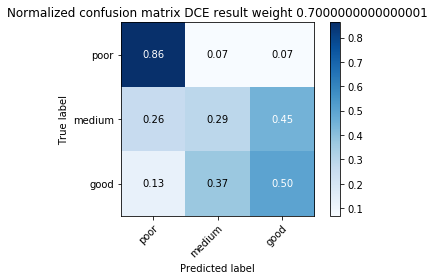

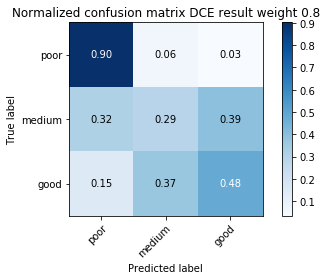

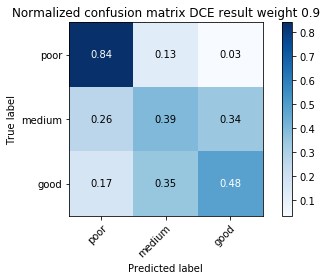

In [356]:
acc_scores_dce = []
classifier_losses_dce = []
for i in range(9):
    acc_scores_dce.append(accuracy_score(y_test,test_y_pred[i]))
    plot_confusion_matrix(y_test, test_y_pred[i], classes=class_names, normalize=True,
                      title='Normalized confusion matrix DCE result weight ' + str(cl_weights[i]) )

    

In [357]:
max(acc_scores_dce) # weight = 0.6

0.7744360902255639

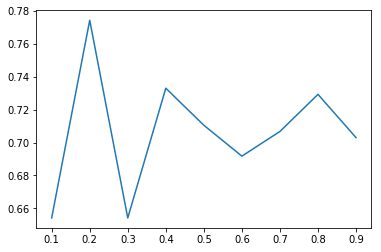

In [359]:
plt.plot(cl_weights,acc_scores_dce)

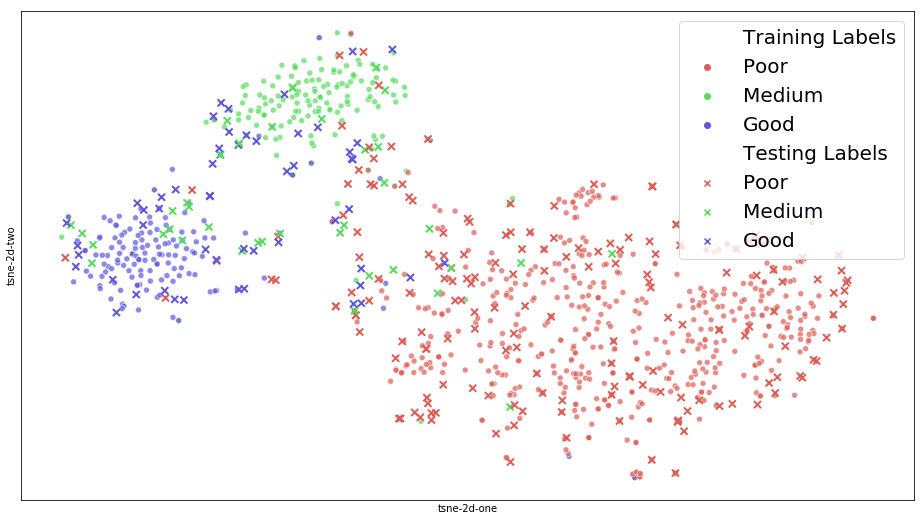

In [360]:
fig, ax =plt.subplots(figsize=(16,9))

utilities.tsne_2d_visulization_test_and_train(
    train_feat=train_hidden_feats[7], 
        train_labels=y_train,
        test_feat=test_hidden_feats[7],
        test_labels=y_test,
        labels=['Poor', 'Medium','Good'],
    verbose=0,
    ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.legend(fontsize=20)
plt.savefig('co_train_classifying_3cluster_tsn_wt0p8.pdf', bbox_inches='tight')

Normalized confusion matrix
[[0.9  0.06 0.03]
 [0.32 0.29 0.39]
 [0.15 0.37 0.48]]


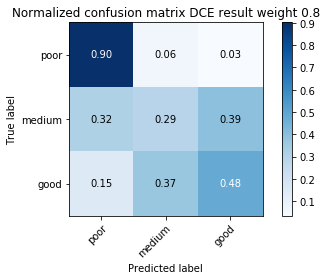

In [361]:
plot_confusion_matrix(y_test, test_y_pred[7], classes=class_names, normalize=True,
                      title='Normalized confusion matrix DCE result weight ' + str(cl_weights[7]) )